In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream as ms
from gala.units import galactic

In [2]:
plt.style.use('notebook')

In [3]:
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

In [4]:
pin = np.load('../data/new_orbit.npy')
phi1, phi2, d, pm1, pm2, vr = pin
ham = gp.Hamiltonian(gp.load('../data/mwpot.yml'))
dt = 0.1 * u.Myr

c = gc.GD1(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, 
        pm_phi1_cosphi2=pm1*u.mas/u.yr,
        pm_phi2=pm2*u.mas/u.yr,
        radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)
fit_orbit = ham.integrate_orbit(w0, dt=dt, n_steps=600)

model_gd1 = fit_orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

In [5]:
ind_prog = np.argmin(np.abs(model_gd1.phi1 + 20*u.deg))

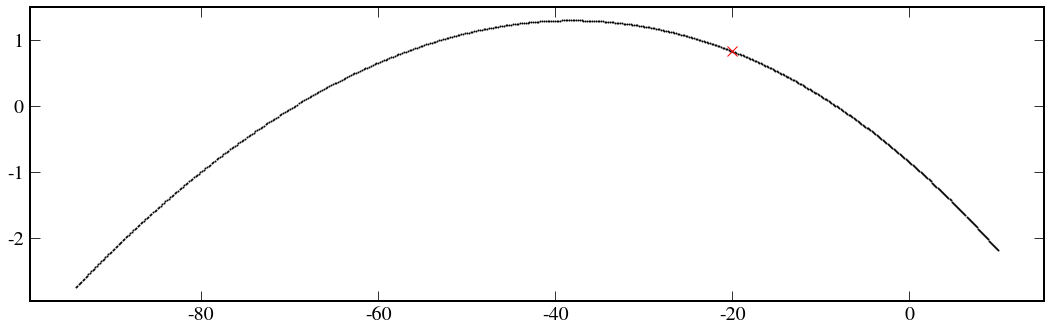

In [6]:
plt.figure(figsize=(15,5))
plt.plot(model_gd1.phi1, model_gd1.phi2, 'ko', ms=1)
plt.plot(model_gd1.phi1[ind_prog], model_gd1.phi2[ind_prog], 'rx', ms=10)

# plt.gca().set_aspect('equal')
plt.tight_layout()

In [7]:
df = ms.FardalStreamDF()

In [36]:
# orbit back
gd1_cen = model_gd1[ind_prog]
rep = gd1_cen.transform_to(gc_frame).data
gd1_w0 = gd.PhaseSpacePosition(rep)
dt = 1*u.Myr
n_steps = 4000

orbit_rr = ham.integrate_orbit(gd1_w0, dt=-dt, n_steps=n_steps)

w0_init = gd.PhaseSpacePosition(orbit_rr.data[-1])
t = np.abs(orbit_rr.t)

In [45]:
np.random.seed(294)

n_disrupt = 500
n_particles = np.ones(n_steps+1, dtype=int)
n_particles[-n_disrupt:] = 0
dt = 0.5*u.Myr

minit = 1e4
mfin = 1e2
nrelease = 1
t_disrupt = -dt*n_disrupt
n_times = (orbit_rr.t < t_disrupt).sum()
prog_mass = np.linspace(minit, mfin, n_times)
prog_mass = np.concatenate((prog_mass, np.zeros(len(orbit_rr.t) - n_times))) * u.Msun

gen_gd1 = ms.MockStreamGenerator(df, ham)
gd1_np, _ = gen_gd1.run(w0_init, prog_mass, dt=dt, t=t, n_particles=n_particles)
gd1_np_eq = gd1_np.to_coord_frame(coord.ICRS)
gd1c_np = gd1_np.to_coord_frame(gc.GD1)
print(np.shape(gd1c_np.phi1), np.shape(t))

(7002,)


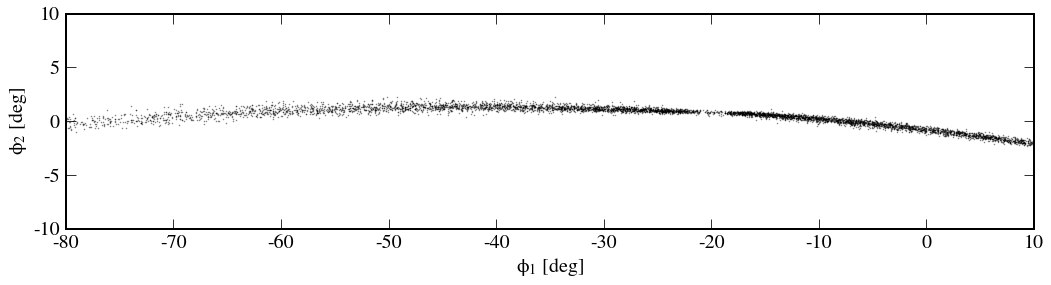

In [47]:
plt.figure(figsize=(15,5))
plt.plot(gd1c_np.phi1[:], gd1c_np.phi2[:], 'k.', ms=1, alpha=0.5)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.xlim(-80, 10)
plt.ylim(-10,10)
plt.gca().set_aspect('equal')
plt.tight_layout()